## Log Probs Experiments

This notebook shows to

In [5]:
import requests
import math
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import dotenv
from openai import OpenAI
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

dotenv.load_dotenv()
client = OpenAI()
openai_model = 'gpt-5-mini-2025-08-07' # OpenAI model to use for logprobs analysis

### 1. Generate Synthetic Dataset

In [6]:
topics = [
    'Technology', 'Sports', 'Politics', 'Art', 'Science', 
    'Health', 'Education', 'Travel', 'Food', 'History'
]

def generate_text_for_topics(topics_list):
    prompt = f"Generate a short, single sentence about {' and '.join(topics_list)}. Do not mention the topic names."
    try:
        response = client.chat.completions.create(
            model='gpt-4o-mini',
            messages=[{'role': 'user', 'content': prompt}],
            temperature=0.7, # A bit of temperature for diversity in text generation
            max_tokens=50
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f'Error generating text with OpenAI: {e}')
        return 'Error generating text.'

dataset = []
# Force regeneration of the dataset using the new model
if os.path.exists('synthetic_dataset.csv'):
    print("Existing synthetic dataset loaded")
    df = pd.read_csv('synthetic_dataset.csv')
    # os.remove('synthetic_dataset.csv')
    # print('Removed existing synthetic_dataset.csv to regenerate.')
else:
    for _ in tqdm(range(100), desc='Generating dataset'):
        num_topics = np.random.randint(1, 4)
        assigned_topics = np.random.choice(topics, num_topics, replace=False).tolist()
        text = generate_text_for_topics(assigned_topics)
        dataset.append({'text': text, 'topics': assigned_topics})
    df = pd.DataFrame(dataset)
    df.to_csv('synthetic_dataset.csv', index=False)

df.head()

Existing synthetic dataset loaded


,text,topics
0,A vibrant expression of human emotion and crea...,['Art']
1,The savory blend of cultures and power struggl...,"['Politics', 'History', 'Food']"
2,Empowering individuals with knowledge and skil...,['Education']
3,The intricate dance of power and influence oft...,['Politics']
4,Creative expression can foster emotional well-...,"['Art', 'Health']"


In [7]:
# pd.set_option('column_width', 120)
pd.set_option('display.max_colwidth', 240)
# df.text = df.text.str.wrap(120)
df.sample(10)

,text,topics
16,"The intersection of societal well-being, governance, and digital innovation is reshaping how communities access and manage their health resources.","['Health', 'Politics', 'Technology']"
63,"Exploring ancient ruins and vibrant cultures allows us to walk through time, connecting past narratives with present adventures.","['History', 'Travel']"
10,"Navigating diverse landscapes, the quest for knowledge intertwines with the ever-shifting tides of governance, while journeys across borders reveal the intricate connections between culture and power.","['Education', 'Politics', 'Travel']"
35,"Exploring new cultures and landscapes enriches the mind and broadens perspectives, transforming every journey into a lesson in life.","['Education', 'Travel']"
58,The echoes of past events shape our understanding of the present and influence the course of the future.,['History']
42,"The relentless pursuit of knowledge transforms the mysteries of the universe into understanding, shaping our future and expanding our horizons.",['Science']
2,Empowering individuals with knowledge and skills paves the way for personal growth and societal advancement.,['Education']
73,Exploring new destinations often leads to delightful culinary adventures that tantalize the senses and create lasting memories.,"['Food', 'Travel']"
17,A balanced lifestyle fosters vitality and enhances overall well-being.,['Health']
51,"The energy from a hearty meal fuels the thrill of competition, uniting athletes and fans in a celebration of passion and perseverance.","['Food', 'Sports']"


## Getting Log Probs

First, lets get the basics down, we will show how to get log probs information from different APIs.

* Ollama, this assumes you have ollama running on your local host with port 11434 (default)
* OpenAI
* 

In [ ]:
# First lets see how models perform normally, under normal conditions
def ollama_prompt(model, prompt, temp=0.5, top_k=10, top_p=0.9, verbose=False):
	url = 'http://localhost:11434/api/generate'
	payload = {
		'model': model,
		'prompt': prompt,
		'stream': False,
		
		"temperature": temp,
		"logprobs": True,
		"top_k": top_k,
		"top_p": top_p,
	}
	try:
		response = requests.post(url, json=payload)
		response.raise_for_status()
		resp_json = response.json()
		if verbose:
			print(f"prompt: {prompt}")
			print(f"response: {resp_json}")
		return resp_json
	except requests.exceptions.RequestException as e:
		print(f'Error getting probs: {e}')  

# Note that not all models support logprobs. Ollama will not raise an error in that case, but simply omit the information from the response body!

ollama_prompt("mistral:latest", "Answer the following question with yes or no only. The capital of the Netherlands is Amsterdam?", verbose=False)

Error getting probs: 404 Client Error: Not Found for url: http://localhost:11434/api/generate


In [36]:
def ollama_prompt_logprobs(model, prompt, **kwargs):
	resp = ollama_prompt(model, prompt, **kwargs)

	result = {}
	top_response = resp['logprobs']
	for token_probs in top_response:
		print(token_probs)

		token = token_probs['token']

		p = math.e ** token_probs['logprob']
		result[token] = p

	return result

# ollama_prompt
# ollama_prompt_logprobs("llama3.1:latest", "Answer the following question with yes or no only. The capital of the Netherlands is Amsterdam?", verbose=False)
ollama_prompt_logprobs("llama3.1:latest", "Answer the following question with yes or no only. The capital of New-Zealand is Wellington?", verbose=False)

{'token': 'Yes', 'logprob': -0.00016516483447048813, 'bytes': [89, 101, 115]}


{'Yes': 0.9998348488044899}

In [ ]:
ollama_prompt_logprobs("llama3.1:latest", "Answer the following question with yes or no only. The capital of New-Zealand is Wellington?", verbose=False)

### Log Probs of Multiple Tokens

When the LLM generates multiple tokens, we need a way to aggregate the log probs over all of them so that we can still have a single log prob value. A simple and common way to do this is <???>



### 2. Ollama Log Probs Analysis

In [ ]:


def process_dataset_ollama(df, model, verbose=False):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing with {model}'):
        probs = get_ollama_topic_probs(row['text'], model=model, verbose=verbose)
        results.append(probs)
    return pd.DataFrame(results)

def analyze_thresholds(y_true, y_prob):
    thresholds = np.linspace(0, 1, 100)
    results = []
    for t in thresholds:
        y_pred = (y_prob > t).astype(int)
        results.append({
            'threshold': t,
            'f1': f1_score(y_true, y_pred, average='samples', zero_division=0),
            'precision': precision_score(y_true, y_pred, average='samples', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='samples', zero_division=0)
        })
    return pd.DataFrame(results)

def plot_analysis(df_analysis, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(df_analysis['threshold'], df_analysis['f1'], label='F1 Score')
    plt.plot(df_analysis['threshold'], df_analysis['precision'], label='Precision')
    plt.plot(df_analysis['threshold'], df_analysis['recall'], label='Recall')
    best_threshold = df_analysis.loc[df_analysis['f1'].idxmax()]
    plt.axvline(x=best_threshold['threshold'], color='r', linestyle='--', label=f'Best Threshold (F1={best_threshold["f1"]:.2f})')
    plt.title(f'Performance vs. Threshold for {model_name}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f'Best threshold for {model_name}: {best_threshold["threshold"]:.2f} with F1={best_threshold["f1"]:.2f}')

In [38]:
df_probs_1.iloc[0]

Technology    0.171057
Sports        0.003984
Politics      0.008226
Art           0.769272
Science       0.093104
Health        0.039622
Education     0.153415
Travel        0.114909
Food          0.000735
History       0.332990
Name: 0, dtype: float64

In [41]:
np.unique(y_true.values)

array([0])

In [42]:
topics

['Technology',
 'Sports',
 'Politics',
 'Art',
 'Science',
 'Health',
 'Education',
 'Travel',
 'Food',
 'History']

In [43]:
pd.get_dummies(df['topics'].explode()).groupby(level=0).sum()

,"['Art', 'Food', 'Technology']","['Art', 'Health']","['Art', 'History', 'Travel']","['Art', 'Sports']",['Art'],"['Education', 'Art']","['Education', 'Food']","['Education', 'Politics', 'Travel']","['Education', 'Politics']","['Education', 'Science', 'Travel']",...,"['Technology', 'Sports', 'Science']","['Technology', 'Travel', 'History']",['Technology'],"['Travel', 'Art', 'Health']","['Travel', 'Health', 'Sports']","['Travel', 'History']","['Travel', 'Politics']","['Travel', 'Science', 'Food']","['Travel', 'Sports']",['Travel']
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_true = pd.get_dummies(df['topics'].explode()).groupby(level=0).sum()
y_true = y_true.reindex(columns=topics, fill_value=0)

ollama_model_1 = 'dolphin-mistral'

top_n = 10

df_probs_1 = process_dataset_ollama(df.head(top_n), ollama_model_1, verbose=True)
# df_probs_1


analysis_1 = analyze_thresholds(y_true.values[:top_n], df_probs_1.values[:top_n])
analysis_1
# plot_analysis(analysis_1, ollama_model_1)

Processing with dolphin-mistral:  10%|█         | 1/10 [00:00<00:02,  3.20it/s]

A vibrant expression of human emotion and creativity, it transcends boundaries and speaks to the soul.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:12.504077Z', 'response': 'Art, Technology', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 330, 13546, 440, 5782, 302, 2930, 13197, 304, 22317, 28725, 378, 24330, 2827, 16824, 304, 19203, 298, 272, 7237, 28723, 13, 13, 6228, 1063, 28747, 13, 260, 32000, 28705, 13, 32001, 13892, 13, 10363, 28725, 12511], 'total_duration': 30646291

Processing with dolphin-mistral:  20%|██        | 2/10 [00:00<00:02,  3.69it/s]

The savory blend of cultures and power struggles simmering in a pot reflects the rich tapestry of human experience, where every bite tells a story of triumphs and trials.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:12.746794Z', 'response': 'Travel, Art', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 415, 8639, 695, 20521, 302, 19826, 304, 1982, 25566, 1290, 794, 288, 297, 264, 2513, 24345, 272, 6708, 12857, 374, 643, 302, 2930, 2659, 28725, 970, 1012, 18082, 8922, 264, 283

Processing with dolphin-mistral:  30%|███       | 3/10 [00:00<00:01,  3.56it/s]

Empowering individuals with knowledge and skills paves the way for personal growth and societal advancement.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:13.039511Z', 'response': 'Technology, Education.', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 10156, 1072, 288, 6992, 395, 4788, 304, 6266, 284, 3410, 272, 1069, 354, 3327, 6057, 304, 25749, 282, 8670, 466, 28723, 13, 13, 6228, 1063, 28747, 13, 260, 32000, 28705, 13, 32001, 13892, 13, 8946, 1818, 2161, 28725, 9352, 2872

Processing with dolphin-mistral:  40%|████      | 4/10 [00:01<00:01,  3.96it/s]

The intricate dance of power and influence often reveals the deepest divides within society.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:13.247081Z', 'response': 'Politics, History', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 415, 7677, 5749, 9773, 302, 1982, 304, 8015, 2608, 21579, 272, 3534, 374, 2901, 1926, 2373, 6190, 28723, 13, 13, 6228, 1063, 28747, 13, 260, 32000, 28705, 13, 32001, 13892, 13, 5096, 279, 1063, 28725, 6866], 'total_duration': 203268292, 'load_durat

Processing with dolphin-mistral:  50%|█████     | 5/10 [00:01<00:01,  3.97it/s]

Creative expression can foster emotional well-being and enhance overall quality of life.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:13.50035Z', 'response': 'Science, Health, Education', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 23626, 5782, 541, 27560, 10526, 1162, 28733, 15823, 304, 11976, 7544, 4045, 302, 1411, 28723, 13, 13, 6228, 1063, 28747, 13, 260, 32000, 28705, 13, 32001, 13892, 13, 28735, 1189, 636, 28725, 6377, 28725, 9352], 'total_duration': 246930333, 'loa

Processing with dolphin-mistral:  60%|██████    | 6/10 [00:01<00:01,  3.94it/s]

Exploring new horizons can awaken the spirit and broaden one's perspective on life.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:13.758091Z', 'response': 'Travel, Education.', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 13702, 4590, 633, 3292, 463, 1053, 541, 2546, 2589, 272, 5838, 304, 5841, 269, 624, 28742, 28713, 10403, 356, 1411, 28723, 13, 13, 6228, 1063, 28747, 13, 260, 32000, 28705, 13, 32001, 13892, 13, 1470, 3177, 28725, 9352, 28723], 'total_duration': 253596292,

Processing with dolphin-mistral:  70%|███████   | 7/10 [00:01<00:00,  3.71it/s]

Exploring new horizons fosters a deeper understanding of the world, inspiring curiosity and innovation in the pursuit of knowledge.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:14.057494Z', 'response': 'Technology, Science, Education', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 13702, 4590, 633, 3292, 463, 1053, 14096, 404, 264, 13551, 6399, 302, 272, 1526, 28725, 5687, 5549, 22953, 304, 16863, 297, 272, 24809, 302, 4788, 28723, 13, 13, 6228, 1063, 28747, 13, 260, 32000,

Processing with dolphin-mistral:  80%|████████  | 8/10 [00:02<00:00,  4.01it/s]

Curiosity drives the relentless pursuit of understanding the fundamental truths of the universe.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:14.263369Z', 'response': 'Science, Technology', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 6119, 2806, 472, 19085, 272, 1016, 308, 1503, 24809, 302, 6399, 272, 11854, 5307, 28713, 302, 272, 11717, 28723, 13, 13, 6228, 1063, 28747, 13, 260, 32000, 28705, 13, 32001, 13892, 13, 28735, 1189, 636, 28725, 12511], 'total_duration': 197693

Processing with dolphin-mistral: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

A balanced lifestyle fosters vitality and enhances overall well-being.
{'model': 'dolphin-mistral', 'created_at': '2026-01-08T04:06:14.491662Z', 'response': 'Health, Education, Art.', 'done': True, 'done_reason': 'stop', 'context': [32001, 1587, 13, 1976, 460, 15052, 721, 262, 28725, 264, 10865, 16107, 13892, 28723, 13, 32000, 28705, 13, 32001, 2188, 13, 13, 2287, 12628, 272, 2296, 2245, 28725, 875, 1575, 378, 778, 624, 442, 680, 302, 272, 2296, 13817, 28747, 12511, 28725, 13184, 28725, 25894, 28725, 3951, 28725, 9323, 28725, 6377, 28725, 9352, 28725, 17823, 28725, 11435, 28725, 6866, 28723, 28705, 13, 2287, 1992, 19571, 395, 264, 432, 705, 28733, 17519, 601, 1274, 302, 272, 1080, 8598, 13817, 865, 28723, 13, 13, 1874, 28747, 330, 19971, 16218, 14096, 404, 12588, 472, 304, 8050, 2233, 7544, 1162, 28733, 15823, 28723, 13, 13, 6228, 1063, 28747, 13, 260, 32000, 28705, 13, 32001, 13892, 13, 18470, 28725, 9352, 28725, 3951, 28723], 'total_duration': 220710042, 'load_duration': 14245292, 'p

,threshold,f1,precision,recall
0,0.000000,0.0,0.0,0.0
1,0.010101,0.0,0.0,0.0
2,0.020202,0.0,0.0,0.0
3,0.030303,0.0,0.0,0.0
4,0.040404,0.0,0.0,0.0
...,...,...,...,...
95,0.959596,0.0,0.0,0.0
96,0.969697,0.0,0.0,0.0
97,0.979798,0.0,0.0,0.0
98,0.989899,0.0,0.0,0.0


### 3. Ollama Model Comparison

Processing with llama3:8b: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


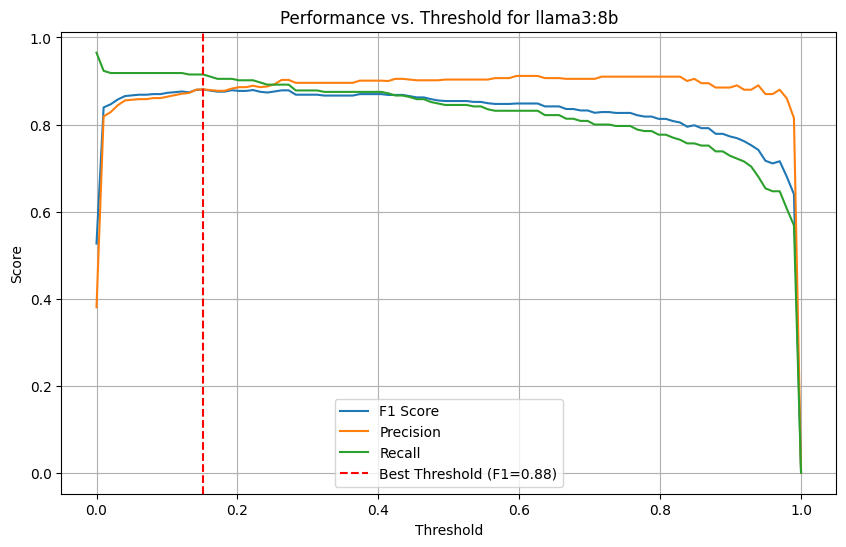

Best threshold for llama3:8b: 0.15 with F1=0.88


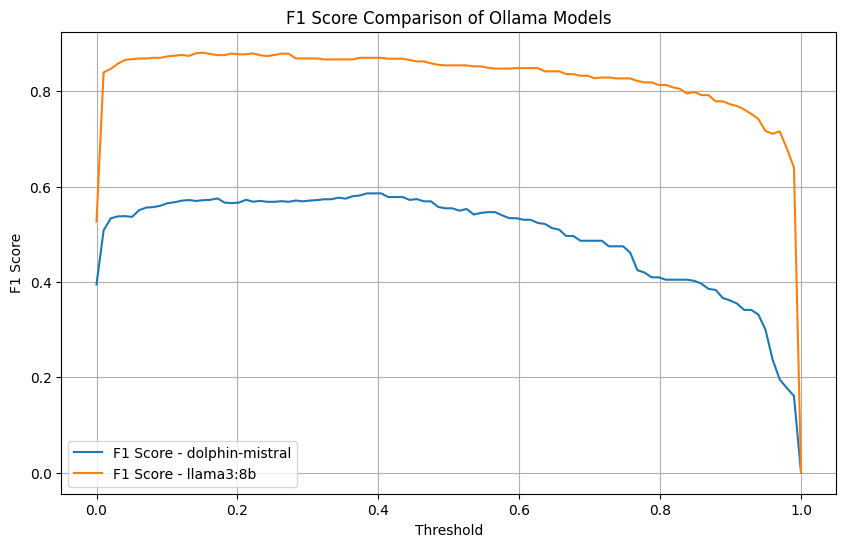

In [10]:
ollama_model_2 = 'llama3:8b'
df_probs_2 = process_dataset_ollama(df, ollama_model_2)
analysis_2 = analyze_thresholds(y_true.values, df_probs_2.values)
plot_analysis(analysis_2, ollama_model_2)

plt.figure(figsize=(10, 6))
plt.plot(analysis_1['threshold'], analysis_1['f1'], label=f'F1 Score - {ollama_model_1}')
plt.plot(analysis_2['threshold'], analysis_2['f1'], label=f'F1 Score - {ollama_model_2}')
plt.title('F1 Score Comparison of Ollama Models')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

### 4. OpenAI Log Probs Analysis

Processing with gpt-4.1-mini: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


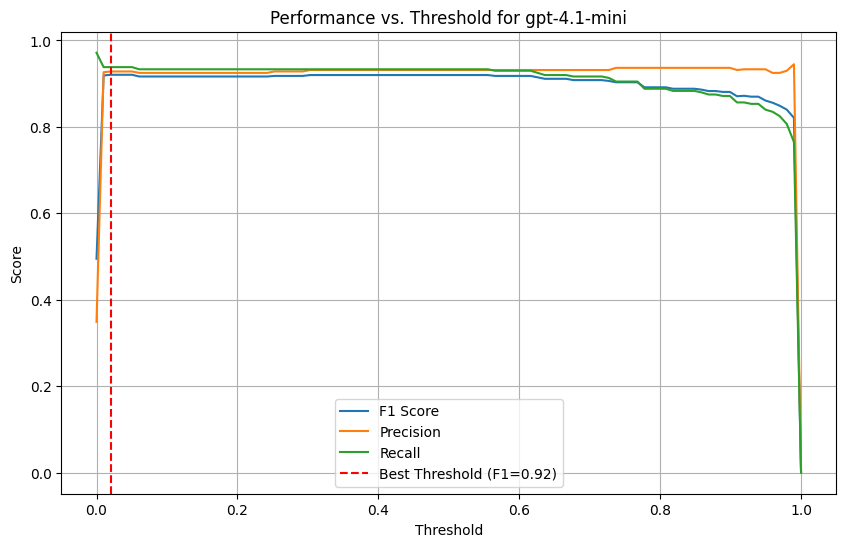

Best threshold for gpt-4.1-mini: 0.02 with F1=0.92


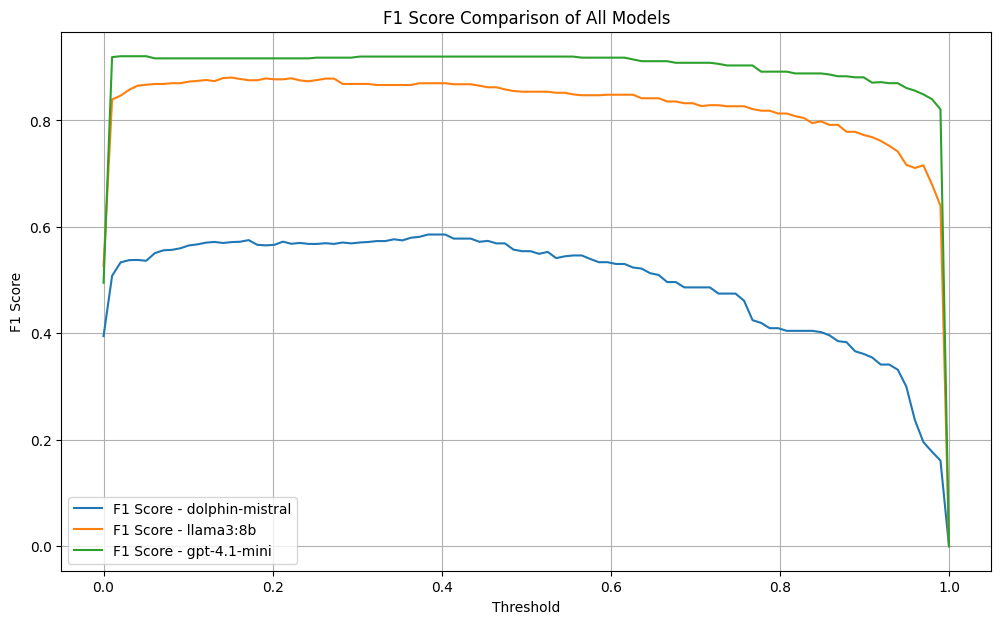

In [13]:
def get_openai_topic_probs(text, model):
    prompt = f"Given the following text, classify it into one or more of the following topics: {', '.join(topics)}. Respond with a comma-separated list of the most relevant topics only.\n\nText: {text}\n\nTopics:"
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{'role': 'user', 'content': prompt}],
            logprobs=True,
            top_logprobs=20,
            temperature=0
        )
        topic_probs = {topic: 0.0 for topic in topics}
        if response.choices[0].logprobs:
            for logprob_info in response.choices[0].logprobs.content:
                for top_logprob in logprob_info.top_logprobs:
                    token_str = top_logprob.token.strip()
                    if token_str in topics:
                        prob = math.exp(top_logprob.logprob)
                        topic_probs[token_str] = max(topic_probs[token_str], prob)
        return topic_probs
    except Exception as e:
        print(f'Error getting OpenAI probs: {e}')
        return {topic: 0.0 for topic in topics}

def process_dataset_openai(df, model):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing with {model}'):
        probs = get_openai_topic_probs(row['text'], model=model)
        results.append(probs)
    return pd.DataFrame(results)

df_probs_openai = process_dataset_openai(df, openai_model)
analysis_openai = analyze_thresholds(y_true.values, df_probs_openai.values)
plot_analysis(analysis_openai, openai_model)

plt.figure(figsize=(12, 7))
plt.plot(analysis_1['threshold'], analysis_1['f1'], label=f'F1 Score - {ollama_model_1}')
plt.plot(analysis_2['threshold'], analysis_2['f1'], label=f'F1 Score - {ollama_model_2}')
plt.plot(analysis_openai['threshold'], analysis_openai['f1'], label=f'F1 Score - {openai_model}')
plt.title('F1 Score Comparison of All Models')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

### 5. Conclusion

This notebook demonstrated a complete workflow for multi-label topic classification using log probabilities from different LLMs. We started by generating a synthetic dataset, then used Ollama and OpenAI models to predict topics. The core of the analysis was to find the optimal probability threshold for converting logprobs into actual topic labels. By plotting precision, recall, and F1-score against various thresholds, we could visually determine the sweet spot for each model that maximizes the F1-score. The final comparison plot shows the relative performance of the models, highlighting that performance can vary significantly and that threshold tuning is a crucial step.

### 6. Experiment 2: Log Probability Stability

This experiment investigates the stability of log probabilities when used for topic classification. We will examine how varying prompt phrasing and label design impacts the consistency of model predictions and their associated log probabilities, even when decoding parameters are fixed.\n\n**Experimental Design:**\n- **Fixed:** Classification task, synthetic dataset, deterministic decoding (temperature=0).\n- **Varied:** Prompt phrasing (semantically equivalent rewordings), label design (short vs. descriptive), model choice (Ollama, OpenAI).\n- **Metrics:** Label rankings, log-probability gaps, and decision changes will be recorded and analyzed.

In [ ]:
def generate_descriptive_labels(topics_list):
    descriptive_labels = {}
    for topic in topics_list:
        prompt = f"Provide a very short, one-sentence descriptive explanation for the topic '{topic}'.\nExample: For 'Sports', provide 'News and discussions related to athletic activities and games.'"
        try:
            response = client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[{'role': 'user', 'content': prompt}],
                temperature=0,
                max_tokens=50
            )
            descriptive_labels[topic] = response.choices[0].message.content.strip()
        except Exception as e:
            print(f"Error generating descriptive label for {topic}: {e}")
            descriptive_labels[topic] = f"Content related to {topic}."
    return descriptive_labels

descriptive_labels = generate_descriptive_labels(topics)

prompt_phrasings = {
    'standard': "Given the following text, classify it into one or more of the following topics: {topics_list}. Respond with a comma-separated list of the most relevant topics only.\n\nText: {text}\n\nTopics:",
    'rephrased': "Analyze the text below and identify all applicable categories from: {topics_list}. Output only a comma-separated list of categories.\n\nText: {text}\n\nCategories:",
    'question': "Which of these topics are most relevant to the following text: {topics_list}? List them, comma-separated.\n\nText: {text}\n\nRelevant topics:"
}

label_designs = {
    'short': topics,
    'descriptive': [f"{t} ({descriptive_labels[t]})" for t in topics]
}

stability_models = {
    'ollama_dolphin-mistral': 'dolphin-mistral',
    'ollama_llama3': 'llama3:8b',
    'openai_gpt-4o-mini': openai_model
}

num_stability_runs = 5
print('Descriptive Labels generated:')
for k, v in descriptive_labels.items():
    print(f'- {k}: {v}')
print(f'Using {len(prompt_phrasings)} prompt phrasings, {len(label_designs)} label designs, {len(stability_models)} models, and {num_stability_runs} runs per configuration.')